# 5. Cell Type Prediction

In this tutorial, we will demonstrate how to use a pretrained Cell2Sentence (C2S) model to perform cell type prediction on single-cell RNA sequencing datasets. Cell type prediction is a crucial step in single-cell analysis, allowing researchers to identify and classify different cell populations within a dataset. By leveraging the power of C2S models, we can make accurate predictions based on the information encoded in cell sentences.

In this tutorial, you will:
1. Load the PBMC 3K dataset from 10x (preprocessed in tutorial notebook 1)
2. Load a pretrained C2S model that is capable of making cell type predictions.
3. Use the model to predict cell types based on the cell sentences derived from the dataset.

We will begin by importing the necessary libraries. These include Python's built-in libraries, third-party libraries for handling numerical computations, progress tracking, and specific libraries for single-cell RNA sequencing data and C2S operations.

In [1]:
# Python built-in libraries
import os
import pickle
import random
from collections import Counter

# Third-party libraries
import numpy as np
from tqdm import tqdm

# Single-cell libraries
import anndata
import scanpy as sc

# Cell2Sentence imports
import cell2sentence as cs
from cell2sentence.tasks import predict_cell_types_of_data

import subprocess
import json
from difflib import SequenceMatcher
import requests
import logging

/home/pieterdb/anaconda3/envs/cell2sentence_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)

In [3]:
import torch
torch.cuda.empty_cache()

# Load Data

Next, we will load the preprocessed dataset from the tutorial 0. This dataset has already been filtered and normalized, so it it ready for transformation into cell sentences.

<font color='red'>Please make sure you have completed the preprocessing steps in Tutorial 0 before running the following code, if you are using your own dataset.</font>. Ensure that the file path is correctly set in <font color='gold'>DATA_PATH</font> to where your preprocessed data was saved from tutorial 0.

In [4]:
DATA_PATH = "./data/pbmc3k_final.h5ad"

In [5]:
adata = anndata.read_h5ad(DATA_PATH)
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'cell_type', 'organism'
    var: 'n_cells'
    uns: 'cell_type_colors', 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_draw_graph_fr', 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [6]:
adata.obs.head()

,n_genes,percent_mito,n_counts,cell_type,organism
index,,,,,
AAACATACAACCAC-1,781,0.030178,2419.0,CD4 T cells,Homo sapiens
AAACATTGAGCTAC-1,1352,0.037936,4903.0,B cells,Homo sapiens
AAACATTGATCAGC-1,1131,0.008897,3147.0,CD4 T cells,Homo sapiens
AAACCGTGCTTCCG-1,960,0.017431,2639.0,CD14+ Monocytes,Homo sapiens
AAACCGTGTATGCG-1,522,0.012245,980.0,NK cells,Homo sapiens


In [7]:
adata.obs['cell_type'].value_counts()

cell_type
CD4 T cells          1144
CD14+ Monocytes       480
B cells               342
CD8 T cells           316
NK cells              154
FCGR3A+ Monocytes     150
Dendritic cells        37
Megakaryocytes         15
Name: count, dtype: int64

<Axes: xlabel='cell_type'>

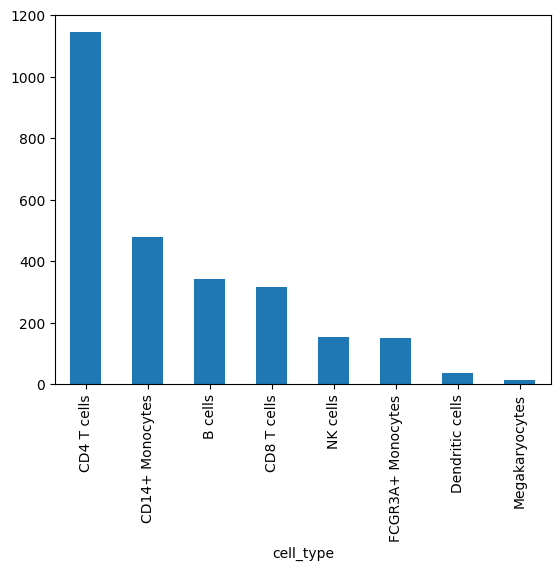

In [8]:
adata.obs['cell_type'].value_counts().plot(kind='bar')

In [9]:
adata.obs['cell_type']

index
AAACATACAACCAC-1        CD4 T cells
AAACATTGAGCTAC-1            B cells
AAACATTGATCAGC-1        CD4 T cells
AAACCGTGCTTCCG-1    CD14+ Monocytes
AAACCGTGTATGCG-1           NK cells
                         ...       
TTTCGAACTCTCAT-1    CD14+ Monocytes
TTTCTACTGAGGCA-1            B cells
TTTCTACTTCCTCG-1            B cells
TTTGCATGAGAGGC-1            B cells
TTTGCATGCCTCAC-1        CD4 T cells
Name: cell_type, Length: 2638, dtype: category
Categories (8, object): ['CD4 T cells', 'CD14+ Monocytes', 'B cells', 'CD8 T cells', 'NK cells', 'FCGR3A+ Monocytes', 'Dendritic cells', 'Megakaryocytes']

In [10]:
#adata.var.head()

/home/pieterdb/anaconda3/envs/cell2sentence_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


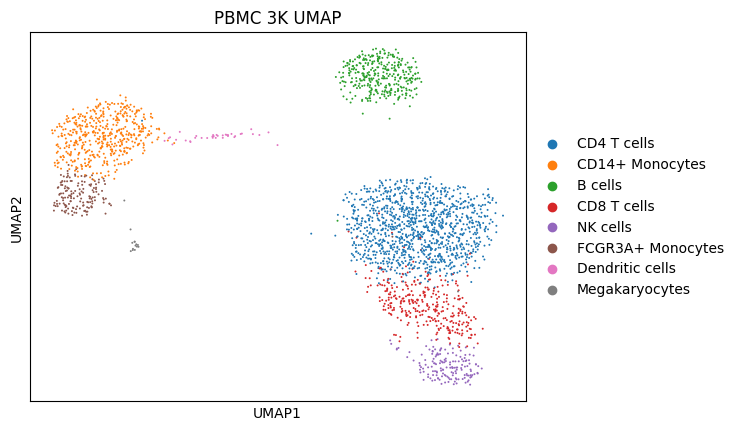

In [11]:
sc.pl.umap(
    adata,
    color="cell_type",
    size=8,
    title="PBMC 3K UMAP",
)

# Cell2Sentence Conversion

In this section, we will transform our AnnData object containing our single-cell dataset into a Cell2Sentence (C2S) dataset by calling the functions of the CSData class in the C2S code base. Full documentation for the functions of the CSData class can be found in the documentation page of C2S.

In [12]:
adata_obs_cols_to_keep = ["cell_type","organism"]

In [13]:
# Create CSData object
arrow_ds, vocabulary = cs.CSData.adata_to_arrow(
    adata=adata, 
    random_state=SEED, 
    sentence_delimiter=' ',
    label_col_names=adata_obs_cols_to_keep
)

100%|██████████| 2638/2638 [00:00<00:00, 18504.71it/s]


In [14]:
arrow_ds

Dataset({
    features: ['cell_name', 'cell_sentence', 'cell_type', 'organism'],
    num_rows: 2638
})

For this exercise we will consider the top 100 genes of the cell sentences

In [15]:
k = 400  # replace with your desired number of genes

arrow_ds = arrow_ds.map(lambda x: {"cell_sentence": " ".join(x["cell_sentence"].split()[:k])})

Map: 100%|██████████| 2638/2638 [00:00<00:00, 43475.22 examples/s]


In [16]:
sample_idx = 0
arrow_ds[sample_idx]

{'cell_name': 'AAACATACAACCAC-1',
 'cell_sentence': 'SPRY1 ZBTB10 ANKRD27 DNMT3A ING5 ZBED5-AS1 NOL7 PAICS HELQ NFKBIL1 TNFRSF25 RIOK1 C19ORF52 MNAT1 APH1B WDR55 MOCS2 RFC2 NR2C2AP C17ORF59 TRABD2A LAMP2 NOL11 ILF3 THEM4 MRPS33 SNRNP27 CCDC174 FXN PHKG2 RRAGC MRPS18A CRLS1 GFER COMMD4 PRR5 SPNS1 SRSF6 CARS GALT POLDIP2 EBNA1BP2 SEPHS2 TRIM69 DIAPH1 ZNF32 SND1 OXLD1 RP11-139H15.1 MFSD10 ISCA2 CLIC3 DDX17 RGS14 GIT2 REXO2 SNHG8 EMB ECHDC1 TMEM205 COMMD8 TREX1 RNF113A TTC3 PEX16 SIAH2 SLC25A11 HOPX PITHD1 LYAR SF3B1 C9ORF142 TMEM165 CCL5 SMS MPC2 LSM14A TCP1 YPEL3 SELPLG PPIG HNRNPH3 C19ORF24 ZC3H15 PPT1 ACTR2 CCT4 EFHD2 MYADM FYB ALKBH7 TERF2IP TMEM14B STUB1 VAMP5 APOBEC3G SRSF5 GADD45B HSP90AA1 SCP2 PNRC1 ARRB2 PSMC5 CTSW ABRACL FUS TRAF3IP3 CD48 ATP5C1 SNX3 ARPC4 CASP4 SRP9 PDIA3 UBE2D3 EIF3D ATP5A1 SF3B5 CEBPB HINT1 RBM3 LTB ARL6IP5 GIMAP4 LIMD2 ID2 UBXN1 VAMP8 YWHAB GTF3A CAPZB ATP5D UBB COTL1 GSTP1 CD37 ARPC1B PTPRCAP LGALS1 ARHGAP6 PDZK1IP1 INSL3 RP11-527L4.5 SPOCD1',
 'cell_type':

In [17]:
sample_idx = 2000
len(arrow_ds[sample_idx]['cell_sentence'].split())

110

# Predict cell types

In [18]:
def get_random_cell_sentences(arrow_ds, sample_size=100):
    """
    Returns a list of randomly sampled cell sentences from arrow_ds.
    
    Parameters:
        arrow_ds (iterable): A collection of cell sentences.
        sample_size (int): Number of samples to extract (default 100).

    Returns:
        list: A list of randomly selected cell sentences.
    """
    try:
        data_list = list(arrow_ds)
    except Exception as e:
        raise ValueError("Unable to convert arrow_ds to a list.") from e

    if len(data_list) < sample_size:
        raise ValueError("Dataset size is smaller than the requested sample size.")
    return random.sample(data_list, sample_size)


In [19]:
def create_prompt(cell):
    """
    Given a cell dictionary, create a prompt that describes the cell sentence,
    cell name, and organism, and asks for the most likely cell type.
    """
    prompt = (
        f"You are given a cell sentence representing a rank-ordered gene expression profile.\n"
        f"Cell Name: {cell['cell_name']}\n"
        f"Organism: {cell['organism']}\n"
        f"Cell Sentence: {cell['cell_sentence']}\n\n"
        "Based on the above gene expression profile, what is the most likely cell type?\n"
        "Select the most appropriate cell type from the following list:\n"
        "'CD4 T cells', 'CD14+ Monocytes', 'B cells', 'CD8 T cells', 'NK cells', 'FCGR3A+ Monocytes', 'Dendritic cells', 'Megakaryocytes'\n"
        "If the cell sentence does not match any of the cell types above, answer with 'unknown'.\n"
        "I only want the cell type name as the answer, without any additional text. Format as follows: 'cell type'.\n"
        "For example, if the cell type is 'CD4 T cells', respond with 'CD4 T cells'.\n"
    )
    return prompt

In [20]:
def query_llama_via_api(prompt: str, model, temperature: float = 0.0) -> str:
    api_url = "http://localhost:11434/api/generate"
    payload = {
        "model": model,
        "prompt": prompt,
        "temperature": temperature,
         }
    model = payload.get("model", "unknown model")
    try:
        response = requests.post(api_url, json=payload, stream=True)
        complete_response = ""
        for line in response.iter_lines():
            if line:
                try:
                    json_data = json.loads(line.decode('utf-8'))
                    if 'response' in json_data:
                        complete_response += json_data['response']
                    if json_data.get('done', False):
                        break
                except json.JSONDecodeError as e:
                    logging.error(f"JSON decoding error: {e}")
                    continue
        markdown_content = f"# Response\n\n{complete_response}"
        return markdown_content, model
    except requests.RequestException as e:
        logging.error(f"API request error: {e}")
        raise

In [21]:
def is_prediction_correct(predicted, annotated, threshold=0.7):
    """
    Compare the predicted cell type with the annotated cell type using a string similarity ratio.
    Returns True if the similarity ratio is above the threshold, else False.
    """
    ratio = SequenceMatcher(None, predicted.lower(), annotated.lower()).ratio()
    return ratio >= threshold

## \_\_MAIN\_\_

In [22]:
cells = get_random_cell_sentences(arrow_ds, sample_size=1000)
print(f"Number of cell sentences: {len(cells)}")

Number of cell sentences: 1000


In [23]:
print(cells[0])

{'cell_name': 'GGACGCTGACGCAT-1', 'cell_sentence': 'MNAT1 TMEM177 WDR91 RP11-367G6.3 ATG7 CDC16 GSTZ1 NUDCD1 ING5 SKAP2 ABHD12 AKAP8 AGPAT1 MZB1 CAPN12 PGM1 RPUSD1 RP11-18H21.1 GLB1 MRPL42 DNAJA3 ZNF92 SNHG12 API5 XRRA1 S1PR5 MLLT6 POLD2 HDDC3 TMEM222 RALBP1 PDZD11 CORO7 ELP5 BABAM1 TNFRSF25 CARS JAGN1 KLRB1 UBE2K YWHAE CCT7 TMEM242 TMEM87A CPSF3L APOBEC3G ISY1 KLRG1 MAEA RAB9A NFU1 TMED5 EBNA1BP2 STX16 RAB2A SND1 U2SURP LYAR GZMK C14ORF1 YIPF3 GZMA ANAPC13 MORF4L2 PSMD14 CSRNP1 NOP58 RP11-349A22.5 RBM4 FAM173A LITAF SRA1 NR3C1 MRPS23 IFI44 PRF1 GYG1 NUDT5 RNF113A CCDC69 PEX16 PRMT2 NCR3 SAMD3 RCN2 MID1IP1 FPR1 C20ORF27 THYN1 TINF2 ETHE1 C9ORF142 SF3B1 MRPS12 FAM32A BBX FBXO7 NME3 SNRPB TAF1D CST7 NDUFA10 MGMT TMEM165 TMEM14C LYPLA1 PLEKHJ1 LGALS3 ILF3-AS1 IL32 CCNG1 CD247 DDX46 POLR2E LSM6 EAPP ARGLU1 WTAP MRPL43 SAT2 CCL5 C1ORF86 SRP9 OCIAD1 PFDN2 CCL4 IFI35 H2AFY RPL22L1 MRP63 HOPX KARS TRAF3IP3 EFHD2 SIVA1 TERF2IP ACP1 RALY NDUFB8-1 ALKBH7 NKG7 GADD45B CD47 FAM96B HSP90AA1 PPP1R2 P

In [24]:
prompt = create_prompt(cells[0])

In [25]:
print(prompt)

You are given a cell sentence representing a rank-ordered gene expression profile.
Cell Name: GGACGCTGACGCAT-1
Organism: Homo sapiens
Cell Sentence: MNAT1 TMEM177 WDR91 RP11-367G6.3 ATG7 CDC16 GSTZ1 NUDCD1 ING5 SKAP2 ABHD12 AKAP8 AGPAT1 MZB1 CAPN12 PGM1 RPUSD1 RP11-18H21.1 GLB1 MRPL42 DNAJA3 ZNF92 SNHG12 API5 XRRA1 S1PR5 MLLT6 POLD2 HDDC3 TMEM222 RALBP1 PDZD11 CORO7 ELP5 BABAM1 TNFRSF25 CARS JAGN1 KLRB1 UBE2K YWHAE CCT7 TMEM242 TMEM87A CPSF3L APOBEC3G ISY1 KLRG1 MAEA RAB9A NFU1 TMED5 EBNA1BP2 STX16 RAB2A SND1 U2SURP LYAR GZMK C14ORF1 YIPF3 GZMA ANAPC13 MORF4L2 PSMD14 CSRNP1 NOP58 RP11-349A22.5 RBM4 FAM173A LITAF SRA1 NR3C1 MRPS23 IFI44 PRF1 GYG1 NUDT5 RNF113A CCDC69 PEX16 PRMT2 NCR3 SAMD3 RCN2 MID1IP1 FPR1 C20ORF27 THYN1 TINF2 ETHE1 C9ORF142 SF3B1 MRPS12 FAM32A BBX FBXO7 NME3 SNRPB TAF1D CST7 NDUFA10 MGMT TMEM165 TMEM14C LYPLA1 PLEKHJ1 LGALS3 ILF3-AS1 IL32 CCNG1 CD247 DDX46 POLR2E LSM6 EAPP ARGLU1 WTAP MRPL43 SAT2 CCL5 C1ORF86 SRP9 OCIAD1 PFDN2 CCL4 IFI35 H2AFY RPL22L1 MRP63 HOPX KARS 

In [26]:

# ollama API call
model = "gemma3:27b"
response, model = query_llama_via_api(prompt, model)


In [27]:
# Extract and print only the last non-empty line from the response.
lines = [line for line in response.splitlines() if line.strip()]
if lines:
    print(lines[-1])

CD4 T cells


In [28]:
correct_count = 0
total = len(cells)

for cell in cells:
    prompt = create_prompt(cell)
    predicted, model = query_llama_via_api(prompt, model)
    lines = [line for line in predicted.splitlines() if line.strip()]
    if lines:
        predicted = lines[-1]
    else:
        predicted = "unknown"

    print(predicted)
    correct = is_prediction_correct(predicted, cell['cell_type'])
    print(f"Cell: {cell['cell_name']}")
    print(f"  Annotated Cell Type: {cell['cell_type']}")
    print(f"  Predicted Cell Type: {predicted}")
    print(f"  Correct Prediction: {correct}\n")
    if correct:
        correct_count += 1

accuracy = (correct_count / total) * 100 if total > 0 else 0
print(f"Accuracy across {total} cells: {accuracy:.2f}%")


CD4 T cells
Cell: GGACGCTGACGCAT-1
  Annotated Cell Type: CD8 T cells
  Predicted Cell Type: CD4 T cells
  Correct Prediction: True

B cells
Cell: AGCTTTACTCTCAT-1
  Annotated Cell Type: B cells
  Predicted Cell Type: B cells
  Correct Prediction: True

CD4 T cells
Cell: AAATCCCTCCACAA-1
  Annotated Cell Type: CD8 T cells
  Predicted Cell Type: CD4 T cells
  Correct Prediction: True

CD14+ Monocytes
Cell: ACTTAGCTGCGTAT-1
  Annotated Cell Type: FCGR3A+ Monocytes
  Predicted Cell Type: CD14+ Monocytes
  Correct Prediction: True

CD4 T cells
Cell: TGATCACTCTCGCT-1
  Annotated Cell Type: CD4 T cells
  Predicted Cell Type: CD4 T cells
  Correct Prediction: True

B cells
Cell: AATAGGGAACCCTC-1
  Annotated Cell Type: B cells
  Predicted Cell Type: B cells
  Correct Prediction: True

CD4 T cells
Cell: ACTACGGACCTATT-1
  Annotated Cell Type: CD4 T cells
  Predicted Cell Type: CD4 T cells
  Correct Prediction: True

CD4 T cells
Cell: AGACGTACCTCTTA-1
  Annotated Cell Type: Dendritic cells
  Pre